Import Library

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import xgboost as xgb
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import RobustScaler
import eli5

Dataset loading. Primary analysis.

In [2]:
# Dataset loading
df = pd.read_hdf('datasets/train_adult.h5')
df.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,True,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,True,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,True,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,True,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,False,0,0,40,Cuba,<=50K


In [3]:
# Сolumn information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int8  
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-Num   32561 non-null  int64 
 5   Martial Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  bool  
 10  Capital Gain    32561 non-null  int16 
 11  Capital Loss    32561 non-null  int16 
 12  Hours per week  32561 non-null  int8  
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: bool(1), int16(2), int64(2), int8(2), object(8)
memory usage: 2.9+ MB


In [5]:
# Statistics for numeric features
df.describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,423.516600,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,3363.342471,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,-31441.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,27828.000000,4356.000000,99.000000


In [6]:
# Distribution of the target variable
df['Target'].value_counts(normalize=True)

<=50K    0.75919
>50K     0.24081
Name: Target, dtype: float64

In [8]:
# Convert target variable to numeric (for model training)
df['Target_cat'] = (df['Target'] != '<=50K').astype('int8')
print(df['Target_cat'].value_counts(normalize=True))

0    0.75919
1    0.24081
Name: Target_cat, dtype: float64


In [9]:
# Checking the dataset for missing values
df.isna().sum()

Age                  0
Workclass         1836
fnlwgt               0
Education            0
Education-Num        0
Martial Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital Gain         0
Capital Loss         0
Hours per week       0
Country            583
Target               0
Target_cat           0
dtype: int64

In [10]:
# Fill in the gaps and remove the uninformative feature fnlwgt
df = df.fillna('None-info')
df = df.drop(columns='fnlwgt')
df.isna().sum()

Age               0
Workclass         0
Education         0
Education-Num     0
Martial Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital Gain      0
Capital Loss      0
Hours per week    0
Country           0
Target            0
Target_cat        0
dtype: int64

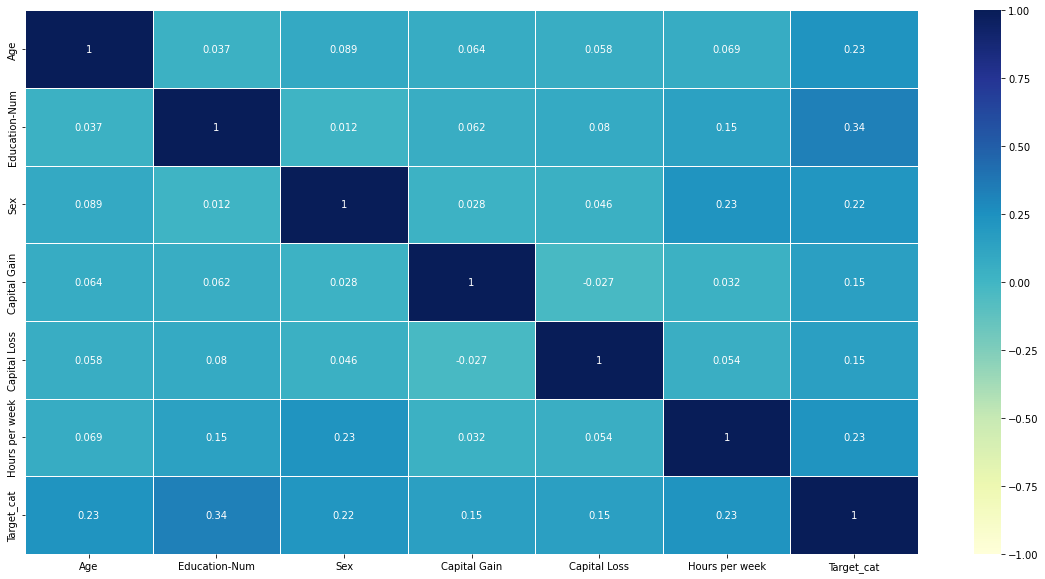

In [12]:
# Consider possible linear correlations between numerical features
# There are weak linear dependences of Education-Num, Hours per week, Age, Sex
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(df.corr(), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

'\nThe graphs show that:\n1-Age - the average age is about 38-40 years. Tail sloped slightly to the right\n2-Education-Num - on average, people were trained for 9-14 years\n3-Capital Gain - values are mostly 0. There are values less than zero. This is most likely a mistake profit cannot be negative.\n4-Capital Loss - losses are also mostly 0. There are values greater than zero.\n5-Hours per week. On average, the number of working hours per week is about 40 hours.\n'

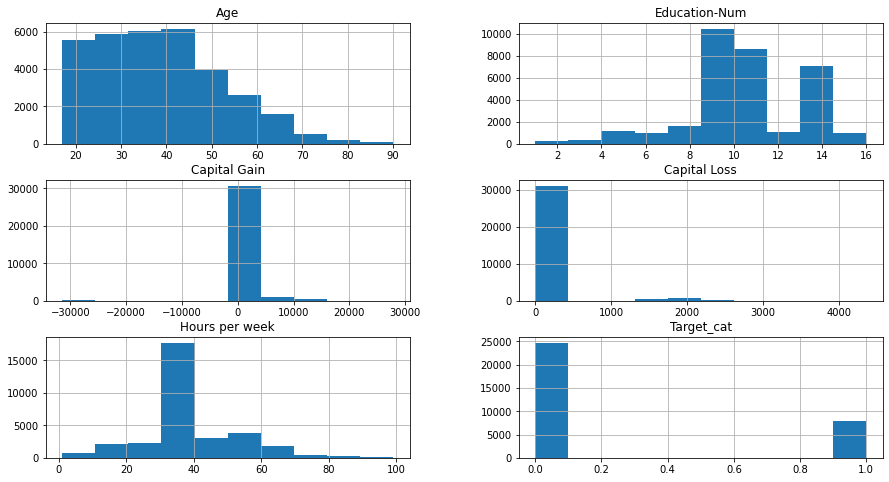

In [14]:
# Посмотрим на все распределения числовых признаков
plt.rcParams['figure.figsize']=(15,8)
df.hist();
'''
The graphs show that:
1-Age - the average age is about 38-40 years. Tail sloped slightly to the right
2-Education-Num - on average, people were trained for 9-14 years
3-Capital Gain - values are mostly 0. There are values less than zero. This is most likely a mistake profit cannot be negative.
4-Capital Loss - losses are also mostly 0. There are values greater than zero.
5-Hours per week. On average, the number of working hours per week is about 40 hours.
'''

In [15]:
# Replace negative values in the Capital Gain column
df['Capital Gain'] = df['Capital Gain'].abs()

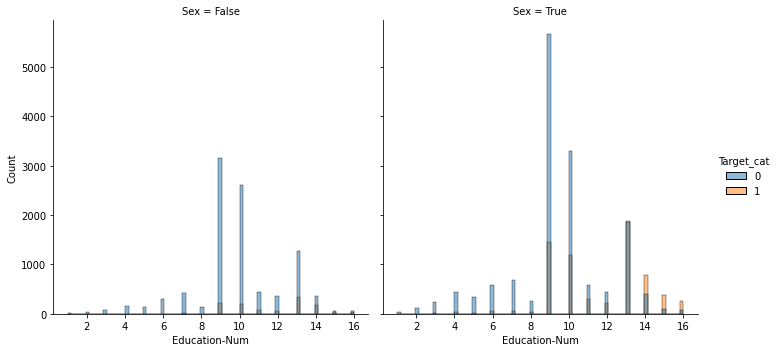

In [17]:
# Let's try to see the distribution of values relative to the target on seaborn histograms
# Education-Num - People who study for 9-10 and 13-16 years are more likely to belong to class №1
# Gender inequality is still visible here. it can be seen that men have a higher chance of class #1
sns.displot(x='Education-Num', data=df, hue='Target_cat', col='Sex');

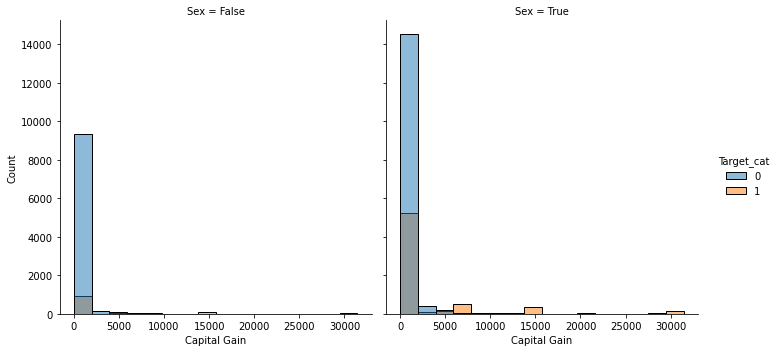

In [18]:
# Consider the Capital Gain feature
# The graph shows that if the profit is greater than 0, then the probability of belonging to class #1 is greater.
sns.displot(x='Capital Gain', data=df, hue='Target_cat', col='Sex');

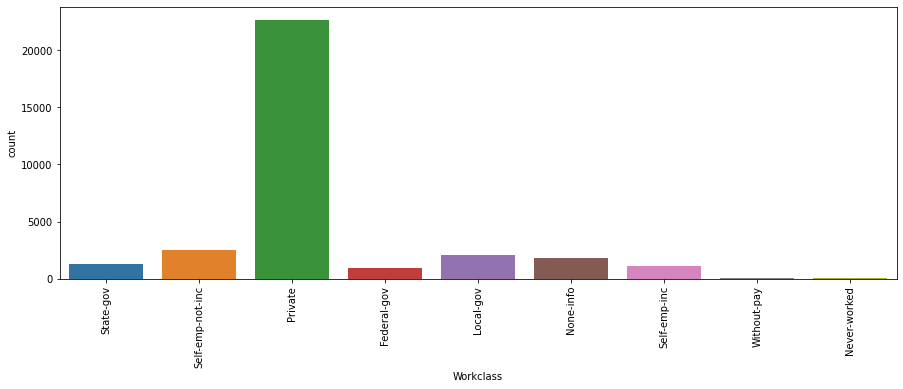

In [19]:
# Let's now look at bar charts for comparing categorical variables
# Workclass - the Private value prevails (greater than 20000)
plt.figure(figsize=(15, 5))
sns.countplot(x='Workclass', data=df);
plt.xticks(rotation=90);

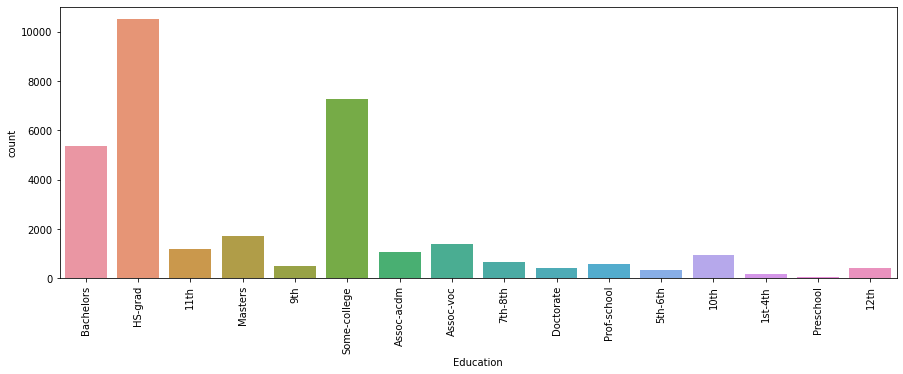

In [28]:
# Education - values are more pronounced in HS-grad, Some-college
plt.figure(figsize=(15, 5))
sns.countplot(x='Education', data=df);
plt.xticks(rotation=90);

<Figure size 1440x360 with 0 Axes>

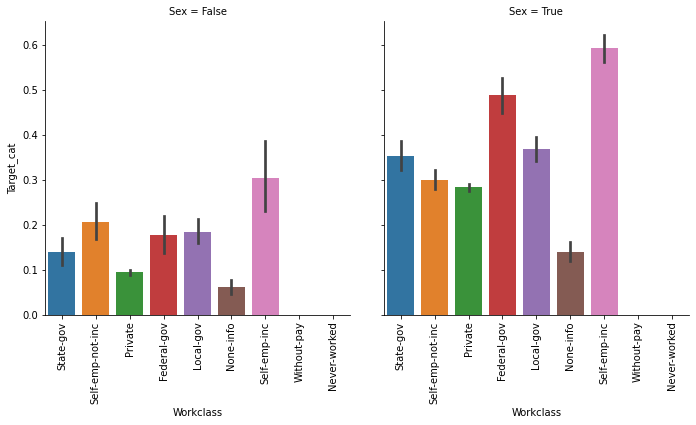

In [20]:
# Comparison of categorical variables with division by Sex
# The most significant variable is Self-emp-inc (Sex=True)
plt.figure(figsize=(20, 5))
g = sns.catplot(x="Workclass", y="Target_cat", col="Sex", data=df, kind="bar")

for ax in g.axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation=90)

<Figure size 1440x360 with 0 Axes>

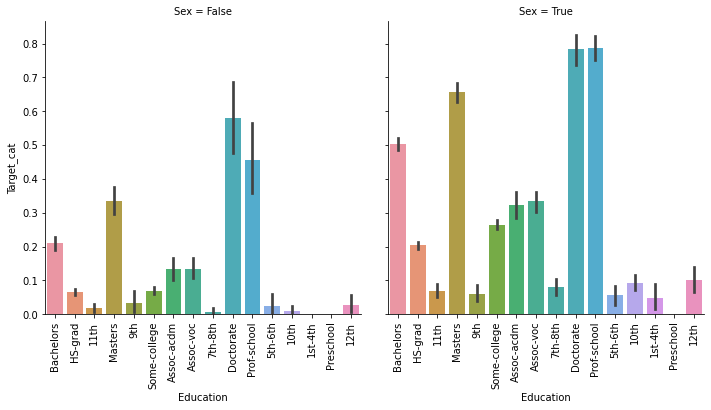

In [21]:
# The most significant variable is Doctorate, Prof-school (Sex=True)
plt.figure(figsize=(20, 5))
g = sns.catplot(x="Education", y="Target_cat", col="Sex", data=df, kind="bar")

for ax in g.axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation=90)

<Figure size 1440x360 with 0 Axes>

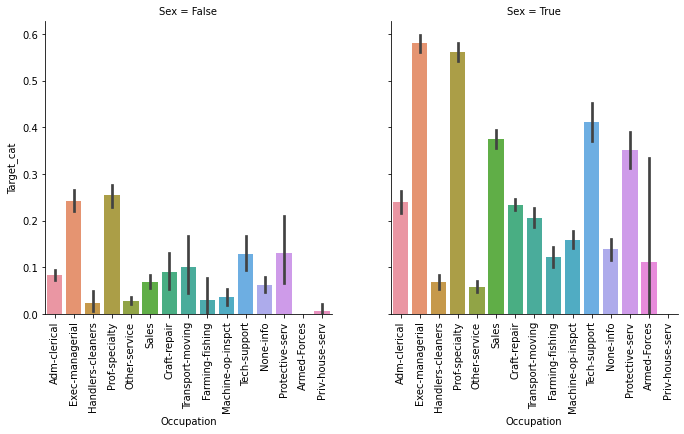

In [22]:
# The most significant variable is Exec-managerial, Prof-specialty (Sex=True)
plt.figure(figsize=(20, 5))
g = sns.catplot(x="Occupation", y="Target_cat", col="Sex", data=df, kind="bar")

for ax in g.axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation=90)

<Figure size 1440x360 with 0 Axes>

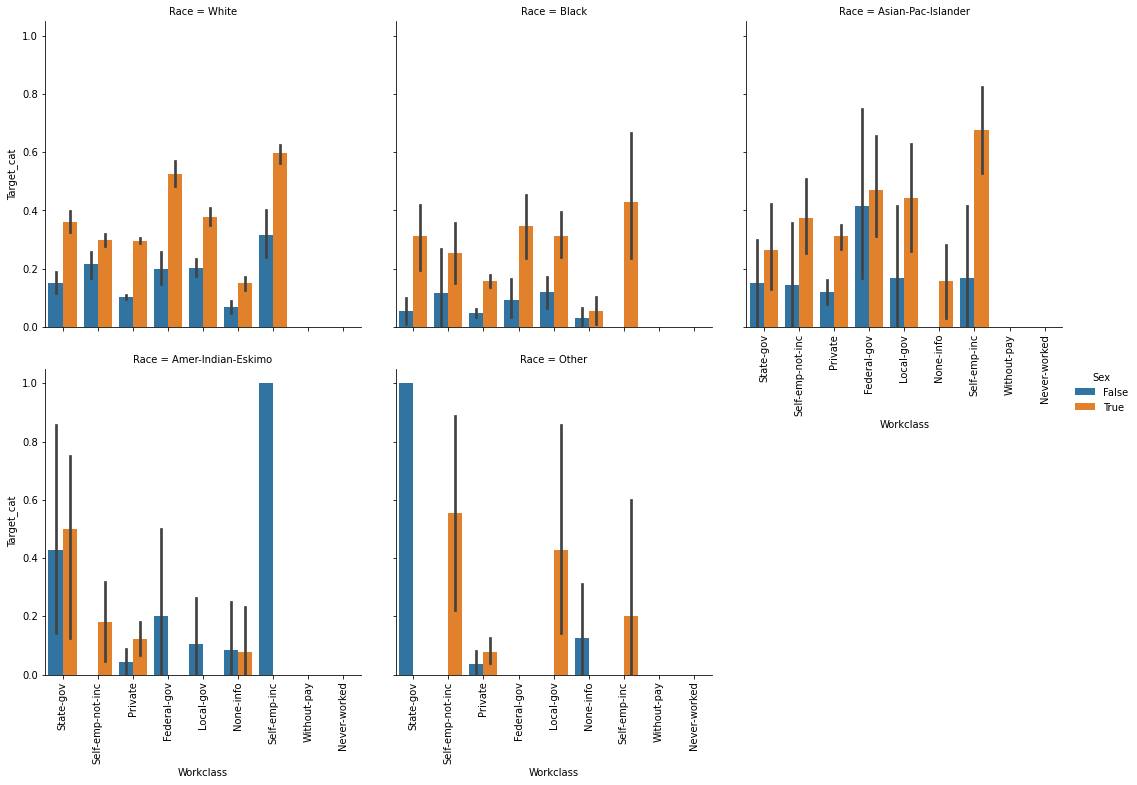

In [23]:
# The most significant variable is Self-emp-inc (Race - Amer-Indian-Escimo - False)
# The most significant variable is State-gov (Race - Other - False)
plt.figure(figsize=(20, 5))
g = sns.catplot(x="Workclass", y="Target_cat", hue="Sex", col="Race", col_wrap=3, data=df, kind="bar")

for ax in g.axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation=90)

<Figure size 1440x360 with 0 Axes>

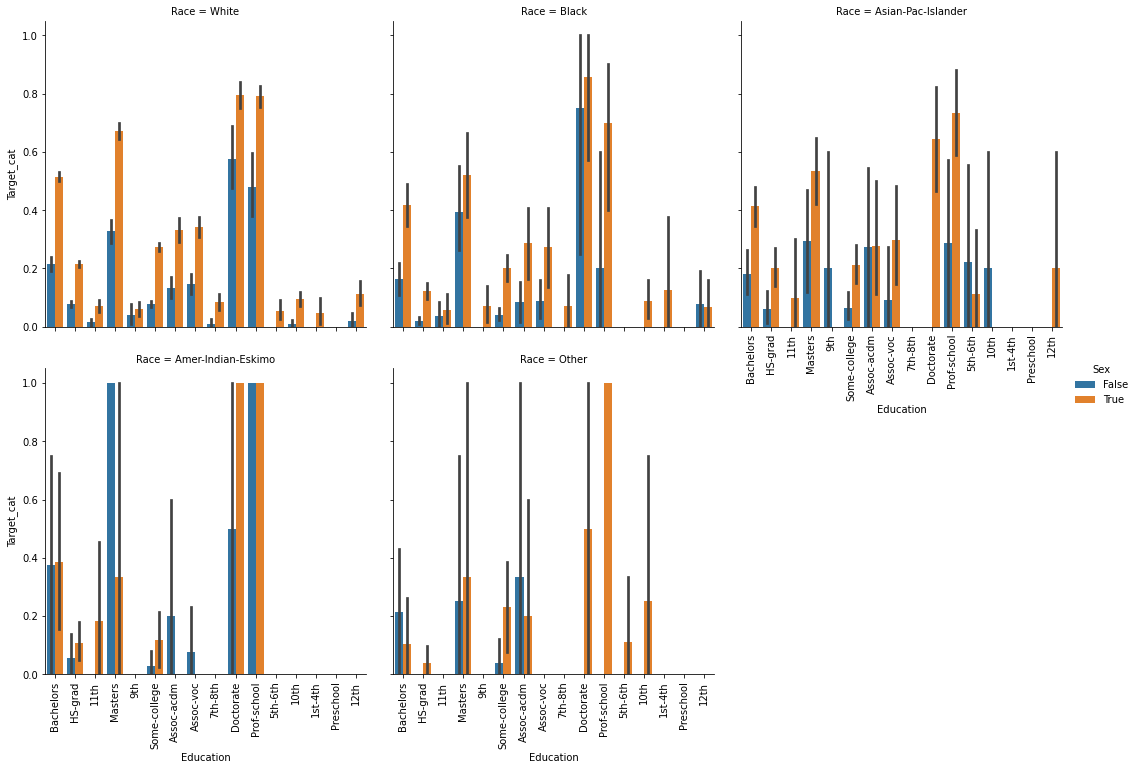

In [24]:
# The most significant variable is Race - Amer-Indian-Escimo (Doctorate, Prof-School)
# The most significant variable is Race - Other (Prof-School)
plt.figure(figsize=(20, 5))
g = sns.catplot(x="Education", y="Target_cat", hue="Sex", col="Race", col_wrap=3, data=df, kind="bar")

for ax in g.axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation=90)

<Figure size 1440x360 with 0 Axes>

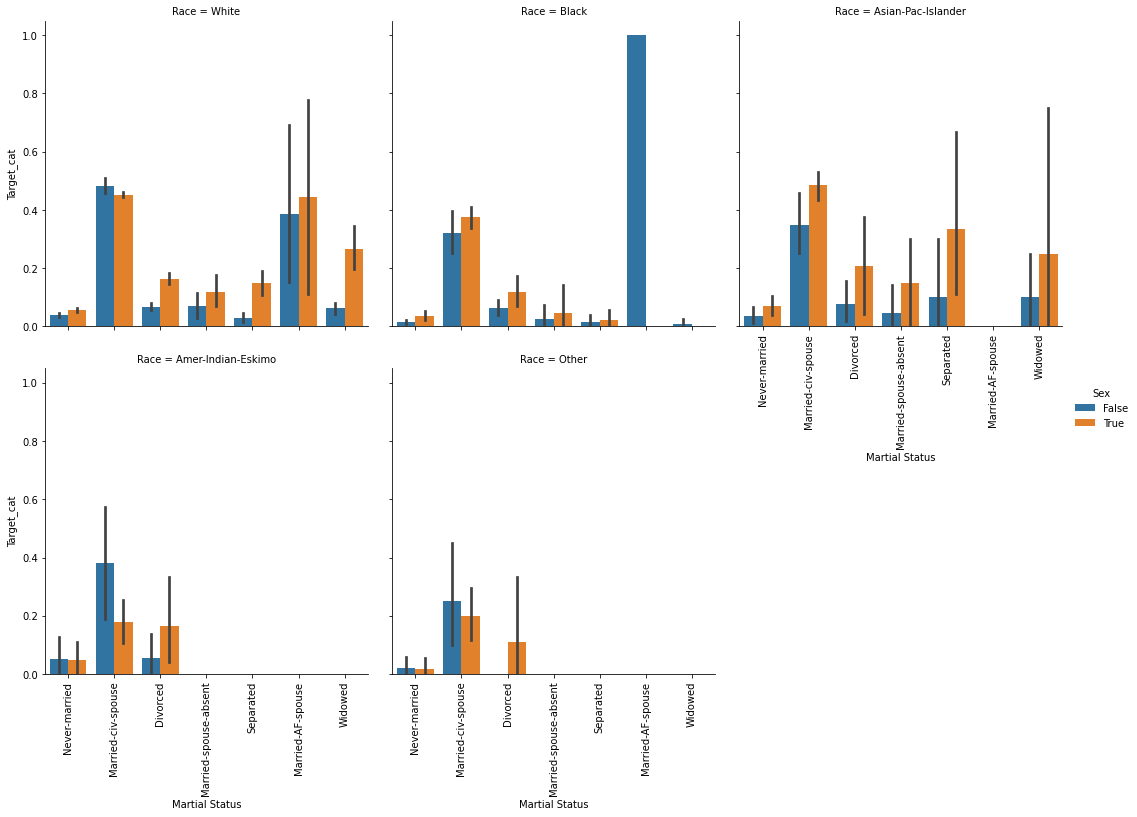

In [25]:
# The most significant variable is Race - Black (Sex=False)
plt.figure(figsize=(20, 5))
g = sns.catplot(x="Martial Status", y="Target_cat", hue="Sex", col="Race", col_wrap=3, data=df, kind="bar")

for ax in g.axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation=90)

The result of the initial analysis:
1. Target variable class imbalance. 75 by 25. You will probably have to use a complex model to correctly classify class #1, or set a threshold when predicting classes, or use SMOTE to generate additional samples to balance classes
2. There is practically no linear relationship between qualitative variables (more precisely, it is weak, to take into account the significance in modeling)
3. The dependence of the target on the Education-Num attribute is visible. The more a person studied, the more likely they are to belong to class #1 (especially among men)
4. The same can be said about the Capital Gain feature. If the profit is greater than zero and Sex=True, then the probability also increases.
5. Education (Sex=True) Doctorate, Prof-School has a high probability of belonging to class #1
6. Workclass (Sex=False) Race - Amer-Indian-Escimo (Self-emp-inc) and Race - Other (State-gov) have a high probability of belonging to class #1
7. Education (Sex=True) Doctorate, Prof-School Race(Amer-Indian-Escimo, Other) has a high probability of belonging to class #1
8. Martial Status (Sex=False) Race - Black (Married-AF-spouse)

Block for generating and optimizing features

In [26]:
# feature engineering
df['Capital_Cat'] = np.where(((df['Capital Gain'] == 0) & (df['Capital Loss'] == 0)), 0, 1)
df['Education_Race'] = df['Education'] + '_' + df['Race']
df['Workclass_Race'] = df['Workclass'] + '_' + df['Race']
df['Martial_Status_Race'] = df['Martial Status'] + '_' + df['Race']


df['Educ-Num_best'] = (df['Education-Num'] > 9) & (df['Education-Num'] < 14)
df['Man_Educ'] = (df['Education'] == 'Doctorate') & (df['Sex'] == True) | (df['Education'] == 'Prof-school') & (df['Sex'] == True)
df['Man_Work'] = (df['Workclass'] == 'Self-emp-inc') & (df['Sex'] == True)
df['Fed_Workclass'] = ((df['Workclass'] == 'Private') & (df['Relationship'] == 'Husband')) | ((df['Workclass'] == 'Private') & (df['Relationship'] == 'Wife'))
df['Family_in'] = (df['Relationship'] == 'Husband') | (df['Relationship'] == 'Wife')
df['Martial_Status_Race_Sex'] = (df['Martial Status'] == 'Married-AF-spouse') & (df['Race'] == 'Black') & (df['Sex'] == 'False')

In [28]:
# Converting categorical groups to numeric
cat_feats = df.select_dtypes(include=[object, bool]).columns

for cat_feat in cat_feats:
	df['{0}_cat'.format(cat_feat)] = pd.factorize(df[cat_feat])[0]


In [29]:
# Уменьшаем размерность числовых значений (для большей производительности)
cols_int16 = ['Education-Num', 'Target_cat', 'Capital_Cat', 'Workclass_cat', 'Education_cat', 'Martial Status_cat', 'Occupation_cat', 'Relationship_cat', 'Race_cat', 'Country_cat', \
              'Sex_cat', 'Country_cat', 'Education_Race_cat', 'Workclass_Race_cat', 'Martial_Status_Race_cat', \
				  'Educ-Num_best_cat', 'Man_Educ_cat', 'Man_Work_cat', 'Fed_Workclass_cat', 'Family_in_cat', 'Martial_Status_Race_Sex']

for col in cols_int16:
    df[col] = df[col].astype('int16')

Model Training

In [31]:
# Function for feature selection
def get_feats(df, black_list = set(['Target_cat'])):
	feats = df.select_dtypes(include=[np.number]).columns
	return [x for x in feats if x not in black_list]

feats= get_feats(df)
feats

['Age',
 'Education-Num',
 'Capital Gain',
 'Capital Loss',
 'Hours per week',
 'Capital_Cat',
 'Martial_Status_Race_Sex',
 'Workclass_cat',
 'Education_cat',
 'Martial Status_cat',
 'Occupation_cat',
 'Relationship_cat',
 'Race_cat',
 'Sex_cat',
 'Country_cat',
 'Education_Race_cat',
 'Workclass_Race_cat',
 'Martial_Status_Race_cat',
 'Educ-Num_best_cat',
 'Man_Educ_cat',
 'Man_Work_cat',
 'Fed_Workclass_cat',
 'Family_in_cat',
 'Martial_Status_Race_Sex_cat']

In [32]:
# X-features, y-target
X = df[feats].values
y = df['Target_cat'].values

# for LogisticRegression we standardize the features
X_std = RobustScaler().fit_transform(X)

In [33]:
# Function for training and predicting models
def model_var(model, X, y, feats, scoring='accuracy', cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True)):

	scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
	print(f'Mean: {round(np.mean(scores) * 100, 2)} %', f'Std: {round(np.std(scores), 4)}')

	skplt.estimators.plot_learning_curve(model, X, y, cv=cv, scoring=scoring, figsize=(15, 5));

	fig = plt.figure(figsize=(15, 6))
	ax1 = fig.add_subplot(121)
	ax2 = fig.add_subplot(122)

	y_pred = cross_val_predict(model, X, y)
	skplt.metrics.plot_confusion_matrix(y, y_pred, normalize=True, ax=ax1)

	model.fit(X, y)

	y_proba = model.predict_proba(X)
	skplt.metrics.plot_roc(y, y_proba, ax=ax2)

	return eli5.show_weights(model, feature_names=feats, top=30)

Mean: 84.68 % Std: 0.0043


c:\Users\Алексей\AppData\Local\Programs\Python\Python39\lib\site-packages\scikitplot\metrics.py:156: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable=image)


Weight?,Feature
+2.221,Family_in_cat
+0.993,Education-Num
+0.444,Age
+0.314,Man_Work_cat
+0.313,Fed_Workclass_cat
+0.147,Hours per week
+0.096,Martial Status_cat
+0.065,Education_cat
+0.028,Workclass_Race_cat
+0.007,Martial_Status_Race_cat


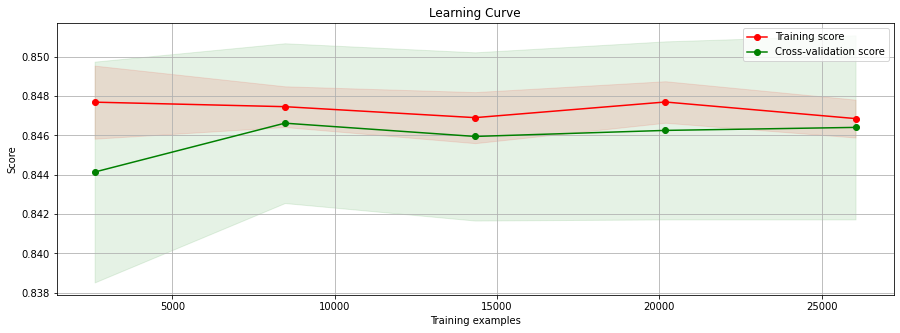

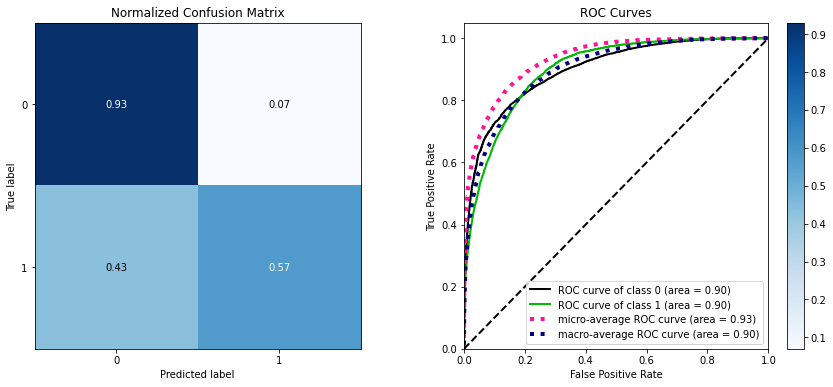

In [34]:
# Checking the performance of the model
# Result 84.68%
model_var(LogisticRegression(max_iter=1000, solver='liblinear'), X_std, y, feats=feats)

Mean: 85.1 % Std: 0.0028


c:\Users\Алексей\AppData\Local\Programs\Python\Python39\lib\site-packages\scikitplot\metrics.py:156: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable=image)


Weight,Feature
0.4657,Family_in_cat
0.2290,Education-Num
0.1969,Capital Gain
0.0455,Capital Loss
0.0232,Capital_Cat
0.0200,Hours per week
0.0108,Age
0.0066,Occupation_cat
0.0023,Sex_cat
0,Martial_Status_Race_Sex


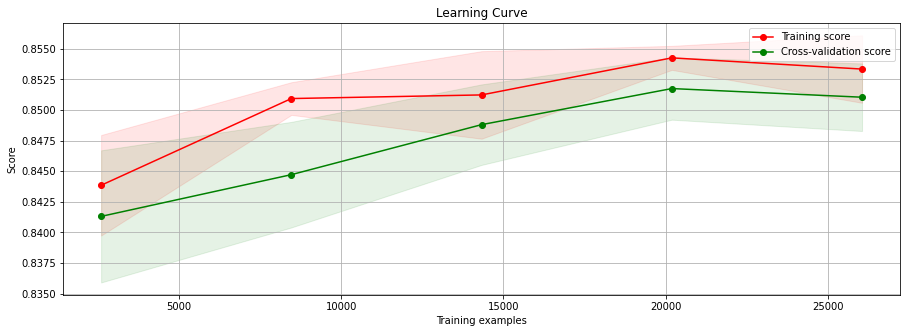

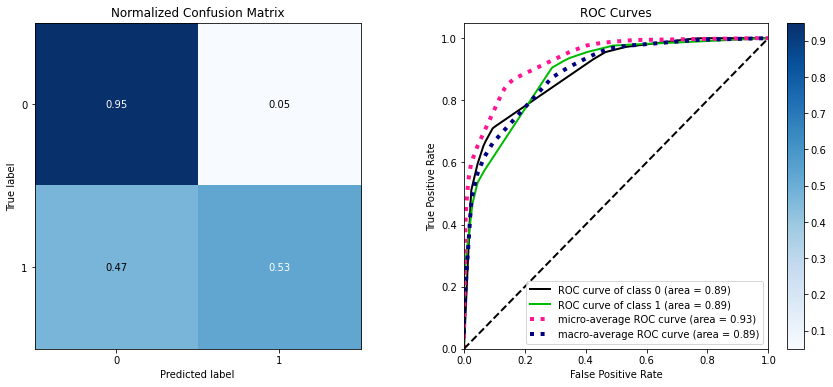

In [35]:
# DecisionTreeClassifier
# Result 85.1%
model_var(DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=0), X, y, feats=feats)

Mean: 87.32 % Std: 0.0028


c:\Users\Алексей\AppData\Local\Programs\Python\Python39\lib\site-packages\scikitplot\metrics.py:156: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable=image)


Weight,Feature
0.3650,Family_in_cat
0.1869,Capital Gain
0.1597,Education-Num
0.0757,Age
0.0604,Capital Loss
0.0394,Hours per week
0.0383,Occupation_cat
0.0147,Relationship_cat
0.0103,Workclass_cat
0.0092,Capital_Cat


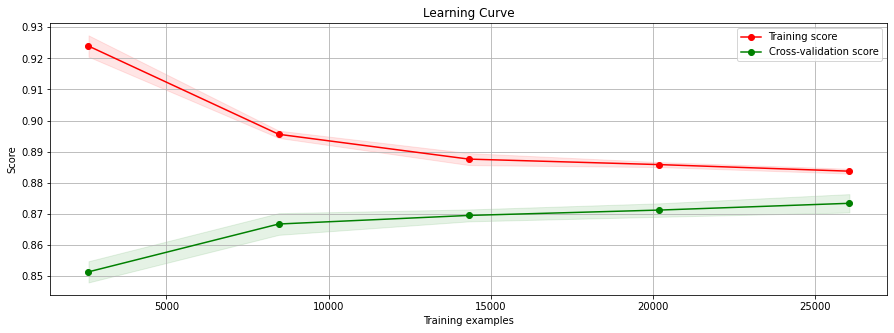

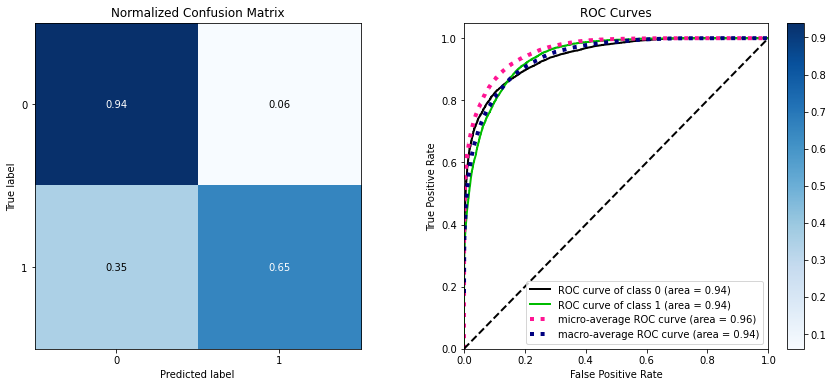

In [36]:
# LGBMClassifier
# Result 87.32%
model_var(lgbm.LGBMClassifier(max_depth=5, n_estimators=50, random_state=0, learning_rate=0.3), X, y, feats=feats)

Creating artificial data for model training with SMOTE

Mean: 89.5 % Std: 0.0014


c:\Users\Алексей\AppData\Local\Programs\Python\Python39\lib\site-packages\scikitplot\metrics.py:156: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(mappable=image)


Weight,Feature
0.3630,Family_in_cat
0.1267,Age
0.1234,Capital Gain
0.1223,Education-Num
0.0898,Occupation_cat
0.0438,Hours per week
0.0291,Capital Loss
0.0256,Sex_cat
0.0133,Relationship_cat
0.0101,Education_Race_cat


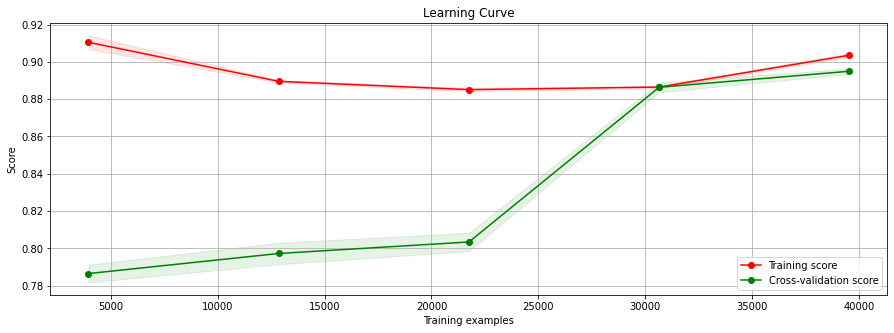

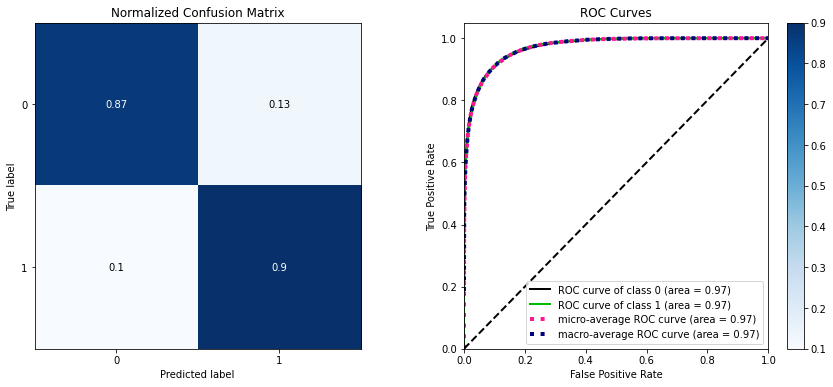

In [37]:
# use the imblearn library
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)

X_2, y_2 = sm.fit_resample(X_std, y)

# LGBMClassifier
# Result 89.5%
model_var(lgbm.LGBMClassifier(max_depth=5, n_estimators=50, random_state=0, learning_rate=0.3), X_2, y_2, feats=feats)

Hyperparameter optimization

In [38]:
# Use the hyperopt module
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [40]:
# Function for Hyperparameter Optimization (LGBMClassifier)
def objective_var_lgbm(space):

    lgmb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'subsample': space['subsample'],
        'learning_rate': space['learning_rate'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'n_estimators': 50
    }
    
    X = df[feats].values
    y = df['Target_cat'].values
    
    cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    
    scores = []
    
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = lgbm.LGBMClassifier(**lgmb_params)
            
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
    
    return{'loss':-1*np.mean(scores), 'status': STATUS_OK }

space = {
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.3),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1)
}

trials = Trials()
best_params = fmin(fn=objective_var_lgbm,
                   space=space,
                   algo=partial(tpe.suggest, n_startup_jobs=5),
                   max_evals=30,
                   trials=trials)

print("The best params: ", best_params)

100%|██████████| 30/30 [01:09<00:00,  2.31s/trial, best loss: -0.8738368613368614]
The best params:  {'x_colsample_bytree': 0.9825804137606756, 'x_learning_rate': 0.18664519875267577, 'x_max_depth': 7.0, 'x_min_child_weight': 2.0, 'x_random_state': 1650.0, 'x_subsample': 0.9897176835300222}


Conclusion:
1. On this dataset, the LGBMClassifier model performed best - 87.32% (can be improved with SMOTE up to 89.5%)